In [1]:
import os
os.getcwd() 

'/Users/izapreev/Projects/ML-PT'

In [2]:
# Make sure the source code auto reloads into the kernel
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils.logger import logger

In [4]:
# Load the provided test data
data_folder = os.path.join('.', 'data')
csv_file_name = os.path.join(data_folder, 'part_10_wrangled.csv')
data_df = pd.read_csv(csv_file_name)

In [5]:
# The only na values are for strings - replace with empty
data_df = data_df.fillna('')
# Infer the best data types
data_df = data_df.convert_dtypes()
# Check on the column types
data_df.dtypes

EVENT_ID                   string
CLIENT_IP                  string
CLIENT_USERAGENT           string
IS_USERAGENT_VALID        boolean
REQUEST_SIZE                Int64
RESPONSE_CODE               Int64
MATCHED_VARIABLE_SRC       string
MATCHED_VARIABLE_NAME      string
MATCHED_VARIABLE_VALUE     string
dtype: object

In [6]:
##############################################################
# 00. The default run with Scaling Enabled and Normalization Disabled
#     Using all columns for features but:
#         EVENT_ID

In [7]:
from src.features.extractor import FeatureExtractor

# Get the features for all the data with Scaling=True and PCA=False the data
extractor_00 = FeatureExtractor(is_scale=True, pca_args=None)
X_00 = extractor_00.fit_transform(data_df)

14:39:57 INFO (extractor:63): Actual Non-Feature Columns: ['EVENT_ID']
14:39:57 INFO (extractor:67): Actual Scaling flag: True
14:39:57 INFO (extractor:75): Actual PCA arguments: None, the PCA is: Disabled
14:39:57 INFO (extractor:112): Start fitting the Feature Extraction model
14:39:57 INFO (extractor:107): Considering feature columns: ['CLIENT_IP', 'CLIENT_USERAGENT', 'IS_USERAGENT_VALID', 'REQUEST_SIZE', 'RESPONSE_CODE', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE']
14:39:57 INFO (extractor:117): Fitting the vectorizer for: "CLIENT_USERAGENT"
14:39:57 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_SRC"
14:39:57 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_NAME"
14:39:58 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_VALUE"
14:39:59 INFO (extractor:128): Start fitting the scaler
14:39:59 INFO (extractor:136): Fitting the Feature Extractor model is done!
14:39:59 INFO (extractor:164): Start 

In [8]:
%%capture
from src.features.utils import create_2d_projection

# Compute the feature space projection
X_00_proj = create_2d_projection(X_00)

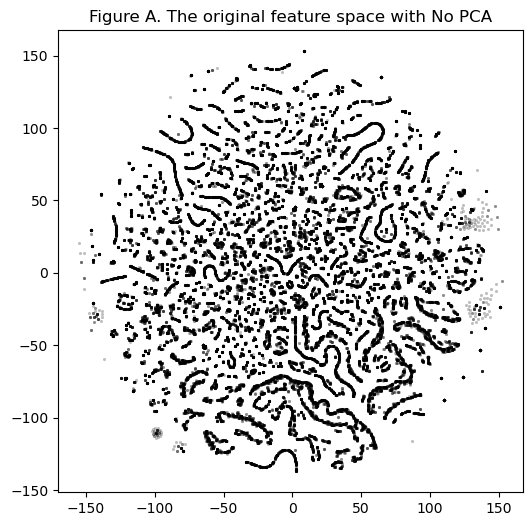

In [9]:
from src.features.utils import plot_2d_feature_space

# Plot the resulting feature space in 2D
plot_2d_feature_space(X_00_proj, title='Figure A. The original feature space with No PCA')

In [10]:
##############################################################
# 01. The default run with Scaling and Normalization Enabled
#     Using all columns for features but:
#         EVENT_ID

In [11]:
# Get the features for all the data with Scaling and PCA the data
extractor_01 = FeatureExtractor()
X_01 = extractor_01.fit_transform(data_df)

14:41:53 INFO (extractor:63): Actual Non-Feature Columns: ['EVENT_ID']
14:41:53 INFO (extractor:67): Actual Scaling flag: True
14:41:53 INFO (extractor:75): Actual PCA arguments: {'n_components': 0.999999}, the PCA is: Enabled
14:41:53 INFO (extractor:112): Start fitting the Feature Extraction model
14:41:53 INFO (extractor:107): Considering feature columns: ['CLIENT_IP', 'CLIENT_USERAGENT', 'IS_USERAGENT_VALID', 'REQUEST_SIZE', 'RESPONSE_CODE', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE']
14:41:53 INFO (extractor:117): Fitting the vectorizer for: "CLIENT_USERAGENT"
14:41:53 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_SRC"
14:41:53 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_NAME"
14:41:53 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_VALUE"
14:41:55 INFO (extractor:128): Start fitting the scaler
14:41:55 INFO (extractor:133): Start fitting the PCA
14:41:55 INFO (extractor:136): Fitting 

14:41:56 INFO (utils:40): The PCA feature name out:
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8']
14:41:56 INFO (extractor:147): The main features contributed to PCA components:
['REQUEST_SIZE', 'CLIENT_IP_6', 'CLIENT_IP_7', 'CLIENT_IP_2', 'CLIENT_IP_5', 'CLIENT_IP_1', 'CLIENT_IP_3', 'CLIENT_IP_4', 'CLIENT_IP_0']
14:41:56 INFO (extractor:148): The variance explained per PCA component:
[9.53298866e-01 2.47787728e-02 2.11552775e-02 4.85953543e-04
 1.50374192e-04 6.44970462e-05 3.06429615e-05 2.49473334e-05
 9.95468631e-06]


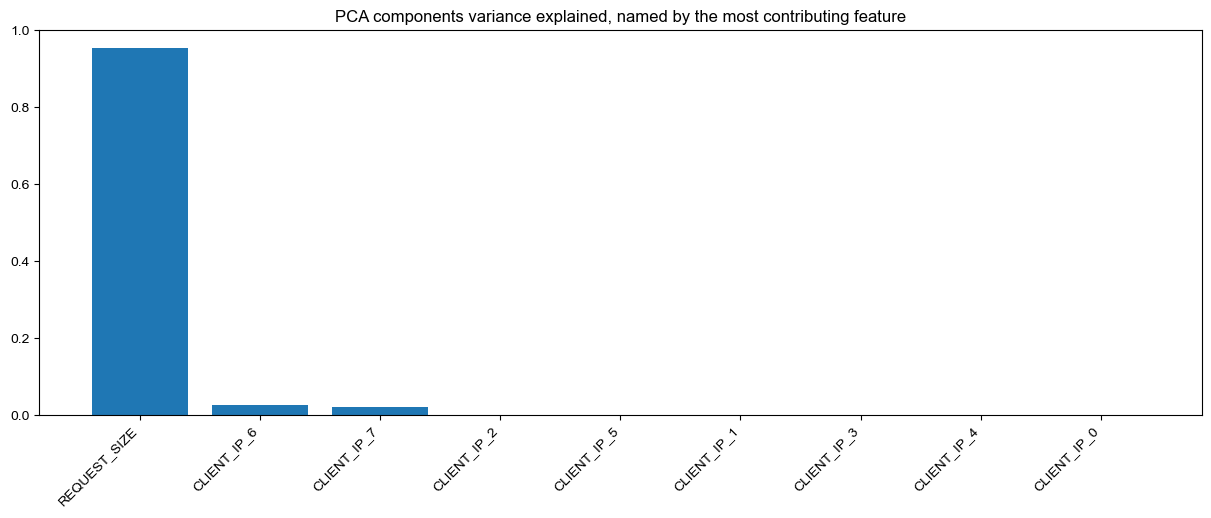

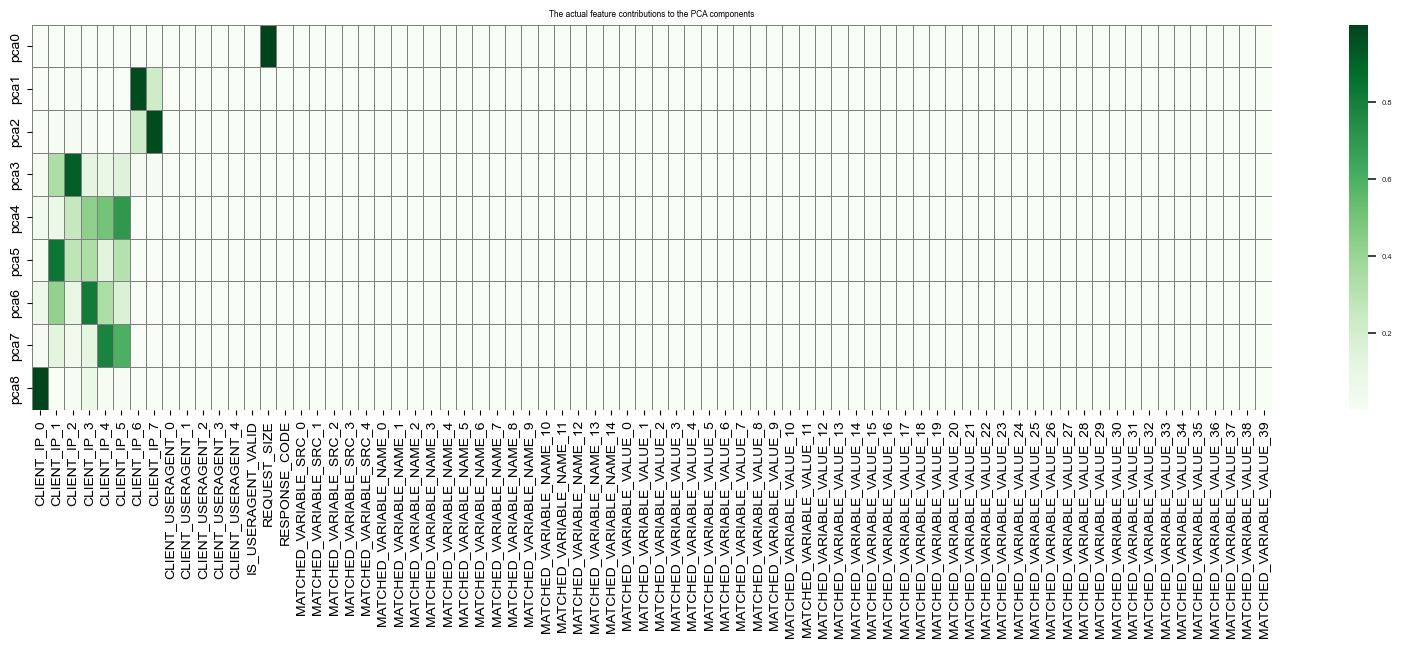

In [12]:
from src.features.utils import plot_variance_explained

# Plot the resulting feature space data
plot_variance_explained(extractor_01)

In [13]:
%%capture
# Compute the feature space projection
X_01_proj = create_2d_projection(X_01)

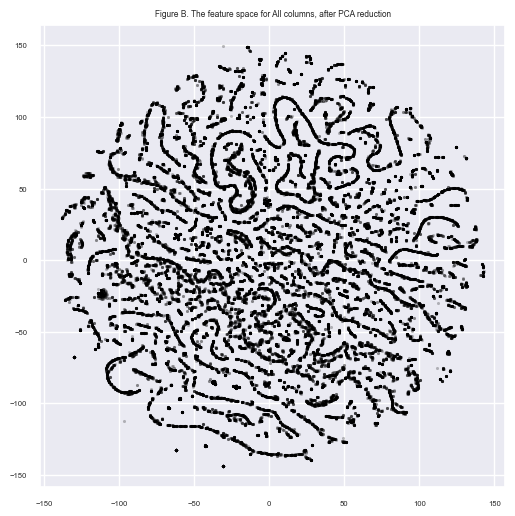

In [14]:
# Plot the resulting feature space in 2D
plot_2d_feature_space(X_01_proj, title='Figure B. The feature space for All columns, after PCA reduction')

In [15]:
# Note: In principle looking at PCA results and tyhe 2D projection of the 
#       original and the reduced space we see that we could just go with
#       CLIENT_IP and REQUEST_SIZE as the main data column to produce features

In [16]:
##############################################################
# 02. The default run with Scaling and Normalization Enabled
#     Using all columns for features but:
#         EVENT_ID, REQUEST_SIZE

In [17]:
# Get the features with additional ignores with Scaling and PCA the data
extractor_02 = FeatureExtractor(ignore_columns=['EVENT_ID', 'REQUEST_SIZE'])
X_02 = extractor_02.fit_transform(data_df)

14:43:47 INFO (extractor:63): Actual Non-Feature Columns: ['EVENT_ID', 'REQUEST_SIZE']
14:43:47 INFO (extractor:67): Actual Scaling flag: True
14:43:47 INFO (extractor:75): Actual PCA arguments: {'n_components': 0.999999}, the PCA is: Enabled
14:43:47 INFO (extractor:112): Start fitting the Feature Extraction model
14:43:47 INFO (extractor:107): Considering feature columns: ['CLIENT_IP', 'CLIENT_USERAGENT', 'IS_USERAGENT_VALID', 'RESPONSE_CODE', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE']
14:43:47 INFO (extractor:117): Fitting the vectorizer for: "CLIENT_USERAGENT"
14:43:47 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_SRC"
14:43:47 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_NAME"
14:43:48 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_VALUE"
14:43:49 INFO (extractor:128): Start fitting the scaler
14:43:49 INFO (extractor:133): Start fitting the PCA
14:43:49 INFO (extractor:136): Fitting 

14:43:50 INFO (utils:40): The PCA feature name out:
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8']
14:43:50 INFO (extractor:147): The main features contributed to PCA components:
['CLIENT_IP_6', 'CLIENT_IP_7', 'CLIENT_IP_2', 'CLIENT_IP_5', 'CLIENT_IP_1', 'CLIENT_IP_3', 'CLIENT_IP_4', 'CLIENT_IP_0', 'RESPONSE_CODE']
14:43:50 INFO (extractor:148): The variance explained per PCA component:
[5.30620654e-01 4.52955585e-01 1.04045868e-02 3.21959818e-03
 1.38091928e-03 6.56083241e-04 5.34136582e-04 2.13135925e-04
 1.52984106e-05]


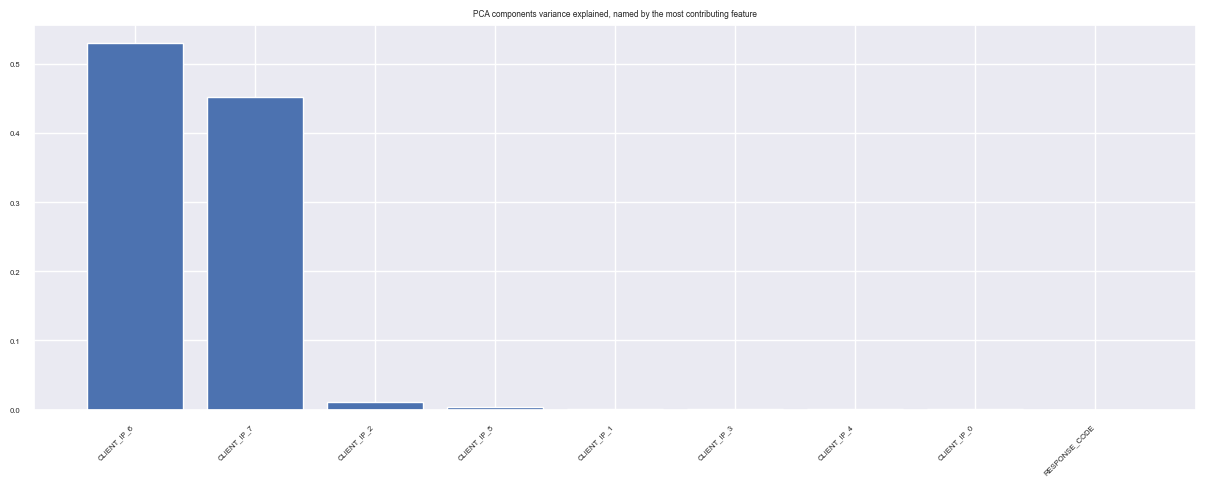

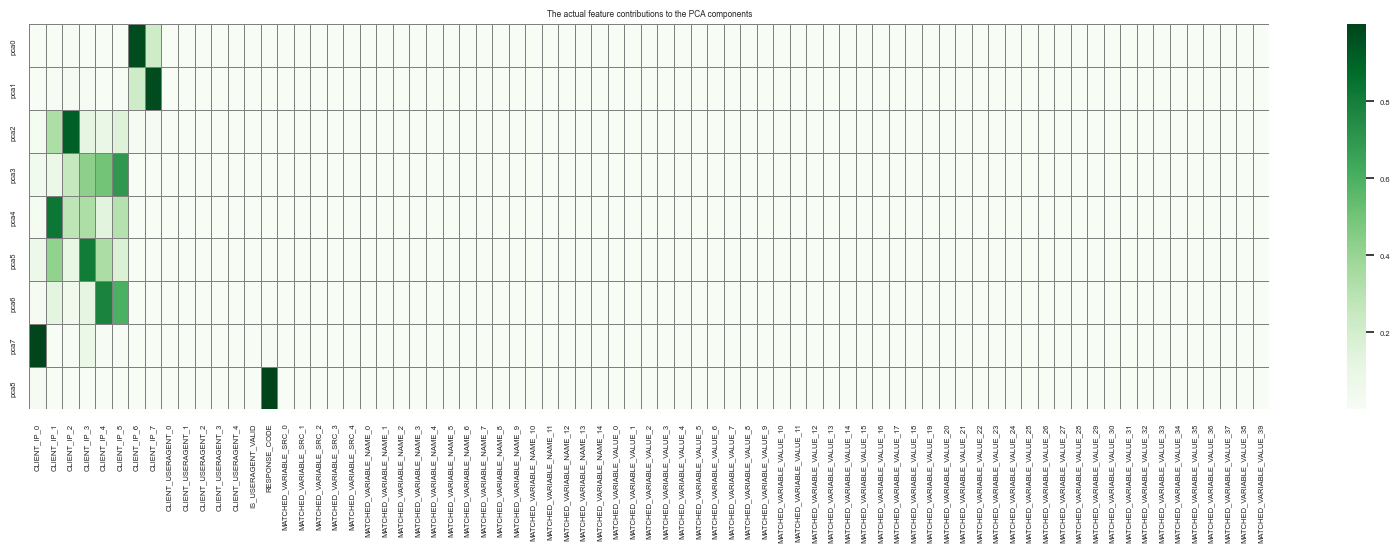

In [18]:
# Plot the resulting feature space data
plot_variance_explained(extractor_02)

In [19]:
##############################################################
# 03. The default run with Scaling and Normalization Enabled
#     Using all columns for features but:
#         EVENT_ID, REQUEST_SIZE, CLIENT_IP

In [20]:
# Get the features with additional ignores with Scaling and PCA the data
extractor_03 = FeatureExtractor(ignore_columns=['EVENT_ID', 'REQUEST_SIZE', 'CLIENT_IP'])
X_03 = extractor_03.fit_transform(data_df)

14:43:51 INFO (extractor:63): Actual Non-Feature Columns: ['EVENT_ID', 'REQUEST_SIZE', 'CLIENT_IP']
14:43:51 INFO (extractor:67): Actual Scaling flag: True
14:43:51 INFO (extractor:75): Actual PCA arguments: {'n_components': 0.999999}, the PCA is: Enabled
14:43:51 INFO (extractor:112): Start fitting the Feature Extraction model
14:43:51 INFO (extractor:107): Considering feature columns: ['CLIENT_USERAGENT', 'IS_USERAGENT_VALID', 'RESPONSE_CODE', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE']
14:43:51 INFO (extractor:117): Fitting the vectorizer for: "CLIENT_USERAGENT"
14:43:52 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_SRC"
14:43:52 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_NAME"
14:43:52 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_VALUE"
14:43:53 INFO (extractor:128): Start fitting the scaler
14:43:53 INFO (extractor:133): Start fitting the PCA
14:43:53 INFO (extractor:136): Fitting 

14:43:54 INFO (utils:40): The PCA feature name out:
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9'
 'pca10' 'pca11' 'pca12' 'pca13' 'pca14' 'pca15' 'pca16' 'pca17' 'pca18'
 'pca19' 'pca20' 'pca21' 'pca22' 'pca23' 'pca24' 'pca25' 'pca26' 'pca27'
 'pca28' 'pca29' 'pca30' 'pca31' 'pca32' 'pca33' 'pca34' 'pca35' 'pca36'
 'pca37' 'pca38' 'pca39' 'pca40' 'pca41' 'pca42' 'pca43' 'pca44' 'pca45']
14:43:54 INFO (extractor:147): The main features contributed to PCA components:
['RESPONSE_CODE', 'MATCHED_VARIABLE_SRC_2', 'CLIENT_USERAGENT_1', 'MATCHED_VARIABLE_SRC_1', 'MATCHED_VARIABLE_SRC_0', 'MATCHED_VARIABLE_SRC_3', 'CLIENT_USERAGENT_3', 'MATCHED_VARIABLE_SRC_4', 'MATCHED_VARIABLE_NAME_0', 'MATCHED_VARIABLE_NAME_9', 'MATCHED_VARIABLE_NAME_11', 'MATCHED_VARIABLE_SRC_4', 'MATCHED_VARIABLE_NAME_11', 'MATCHED_VARIABLE_NAME_8', 'CLIENT_USERAGENT_3', 'MATCHED_VARIABLE_SRC_3', 'MATCHED_VARIABLE_VALUE_31', 'MATCHED_VARIABLE_VALUE_31', 'MATCHED_VARIABLE_NAME_8', 'MATCHED_VARIABL

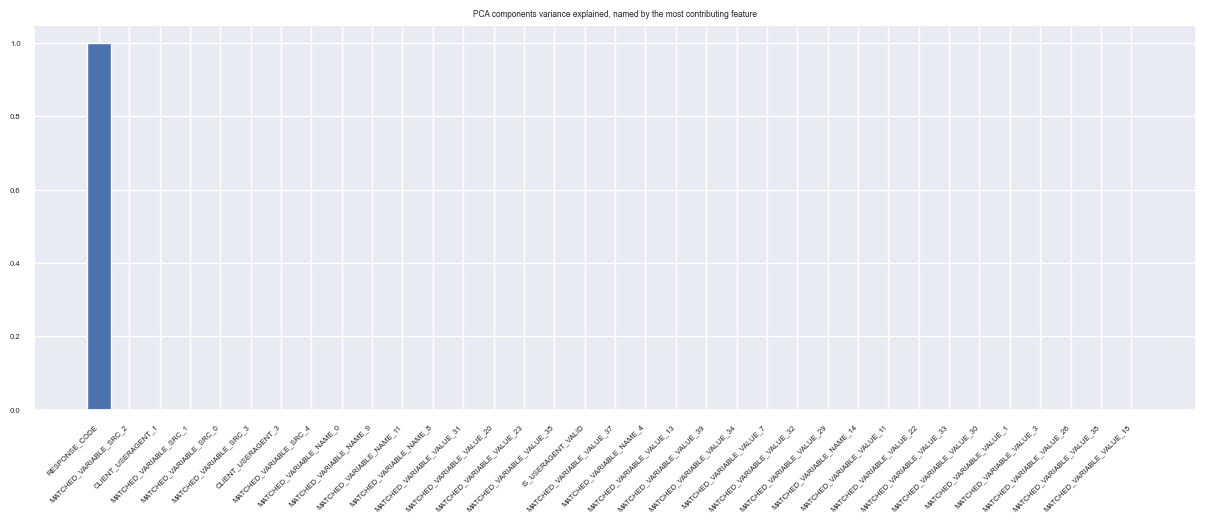

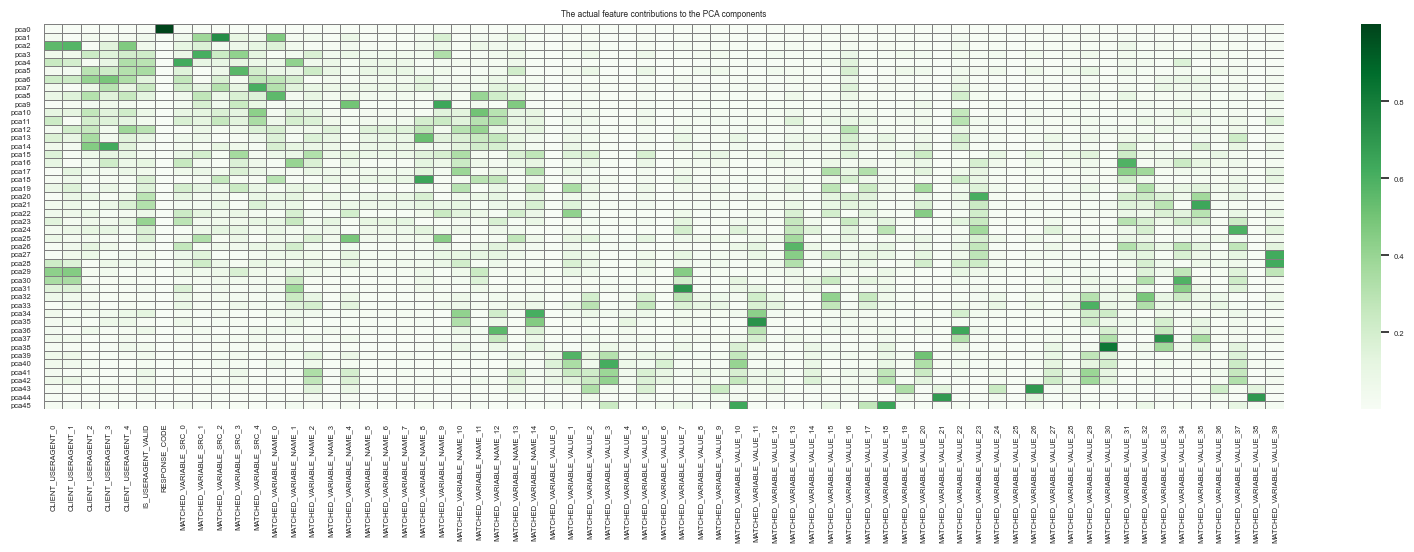

In [21]:
# Plot the resulting feature space data
plot_variance_explained(extractor_03)

In [22]:
##############################################################
# 04. The default run with Scaling and Normalization Enabled
#     Using all columns for features but:
#         EVENT_ID, REQUEST_SIZE, CLIENT_IP, RESPONSE_CODE

In [23]:
# Get the features with additional ignores with Scaling and PCA the data
extractor_04 = FeatureExtractor(ignore_columns=['EVENT_ID', 'REQUEST_SIZE', 'CLIENT_IP', 'RESPONSE_CODE'])
X_04 = extractor_04.fit_transform(data_df)

14:43:55 INFO (extractor:63): Actual Non-Feature Columns: ['EVENT_ID', 'REQUEST_SIZE', 'CLIENT_IP', 'RESPONSE_CODE']
14:43:55 INFO (extractor:67): Actual Scaling flag: True
14:43:55 INFO (extractor:75): Actual PCA arguments: {'n_components': 0.999999}, the PCA is: Enabled
14:43:55 INFO (extractor:112): Start fitting the Feature Extraction model
14:43:55 INFO (extractor:107): Considering feature columns: ['CLIENT_USERAGENT', 'IS_USERAGENT_VALID', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE']
14:43:55 INFO (extractor:117): Fitting the vectorizer for: "CLIENT_USERAGENT"
14:43:56 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_SRC"
14:43:56 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_NAME"
14:43:56 INFO (extractor:117): Fitting the vectorizer for: "MATCHED_VARIABLE_VALUE"
14:43:57 INFO (extractor:128): Start fitting the scaler
14:43:57 INFO (extractor:133): Start fitting the PCA
14:43:57 INFO (extractor:136): Fitting 

14:43:58 INFO (utils:40): The PCA feature name out:
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9'
 'pca10' 'pca11' 'pca12' 'pca13' 'pca14' 'pca15' 'pca16' 'pca17' 'pca18'
 'pca19' 'pca20' 'pca21' 'pca22' 'pca23' 'pca24' 'pca25' 'pca26' 'pca27'
 'pca28' 'pca29' 'pca30' 'pca31' 'pca32' 'pca33' 'pca34' 'pca35' 'pca36'
 'pca37' 'pca38' 'pca39' 'pca40' 'pca41' 'pca42' 'pca43' 'pca44' 'pca45'
 'pca46' 'pca47' 'pca48' 'pca49' 'pca50' 'pca51' 'pca52' 'pca53' 'pca54'
 'pca55' 'pca56' 'pca57' 'pca58' 'pca59' 'pca60' 'pca61' 'pca62' 'pca63'
 'pca64']
14:43:58 INFO (extractor:147): The main features contributed to PCA components:
['MATCHED_VARIABLE_SRC_2', 'CLIENT_USERAGENT_0', 'MATCHED_VARIABLE_SRC_1', 'MATCHED_VARIABLE_SRC_0', 'MATCHED_VARIABLE_SRC_3', 'CLIENT_USERAGENT_3', 'MATCHED_VARIABLE_SRC_4', 'MATCHED_VARIABLE_NAME_11', 'MATCHED_VARIABLE_NAME_9', 'MATCHED_VARIABLE_SRC_4', 'MATCHED_VARIABLE_NAME_11', 'MATCHED_VARIABLE_NAME_11', 'MATCHED_VARIABLE_NAME_8', 'CLIENT_US

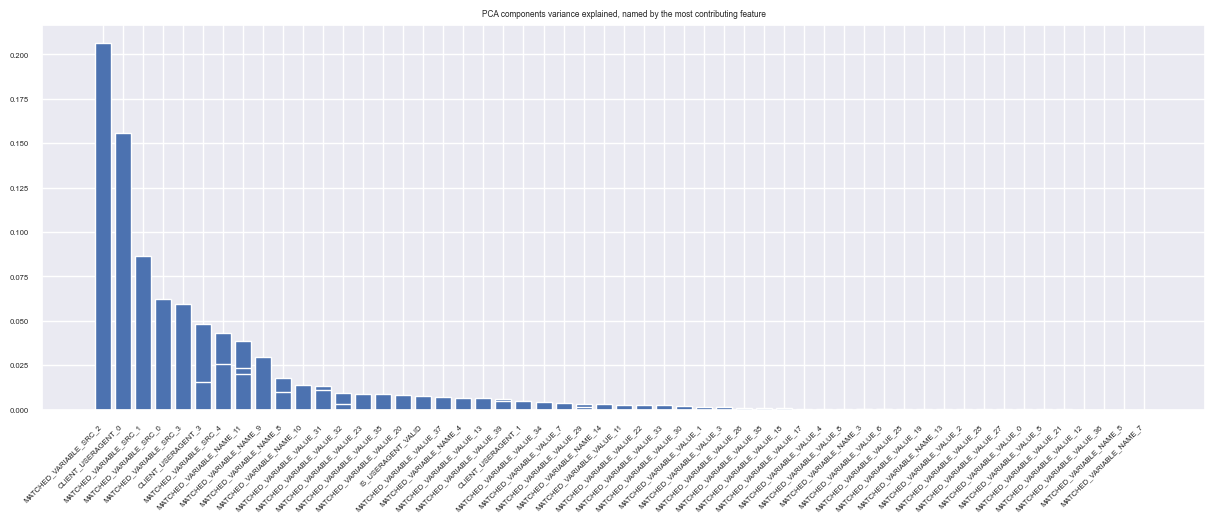

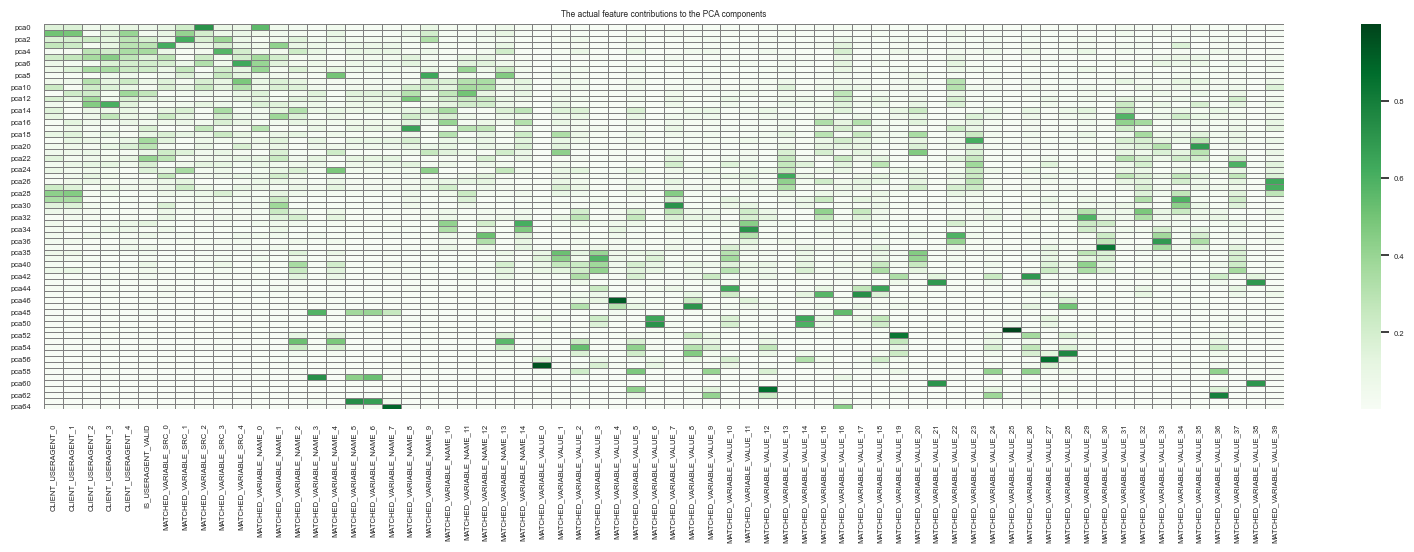

In [24]:
# Plot the resulting feature space data
plot_variance_explained(extractor_04)

In [25]:
##############################################################
# 05. The default run with Scaling and Normalization Enabled
#     Using only 'CLIENT_IP', 'REQUEST_SIZE', and 'RESPONSE_CODE'
#     columns for features

In [26]:
# Devise the columns to be ignored
ignore_columns = [ col_name for col_name in data_df.columns.values if col_name not in ['REQUEST_SIZE', 'CLIENT_IP', 'RESPONSE_CODE']]
logger.info(f'The columns to ignore:\n{ignore_columns}')

14:43:59 INFO (1515489764:3): The columns to ignore:
['EVENT_ID', 'CLIENT_USERAGENT', 'IS_USERAGENT_VALID', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE']


In [27]:
# Extract the features
extractor_05 = FeatureExtractor(ignore_columns=ignore_columns)
X_05 = extractor_05.fit_transform(data_df)

14:43:59 INFO (extractor:63): Actual Non-Feature Columns: ['EVENT_ID', 'CLIENT_USERAGENT', 'IS_USERAGENT_VALID', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE']
14:43:59 INFO (extractor:67): Actual Scaling flag: True
14:43:59 INFO (extractor:75): Actual PCA arguments: {'n_components': 0.999999}, the PCA is: Enabled
14:43:59 INFO (extractor:112): Start fitting the Feature Extraction model
14:43:59 INFO (extractor:107): Considering feature columns: ['CLIENT_IP', 'REQUEST_SIZE', 'RESPONSE_CODE']
14:43:59 INFO (extractor:128): Start fitting the scaler
14:43:59 INFO (extractor:133): Start fitting the PCA
14:43:59 INFO (extractor:136): Fitting the Feature Extractor model is done!
14:43:59 INFO (extractor:164): Start transforming the data with the Feature Extraction model
14:43:59 INFO (extractor:171): Starting the scaler transform
14:43:59 INFO (extractor:176): Starting the PCA transform, the initial X shape: (57833, 10)
14:43:59 INFO (extractor:178): The X shape a

14:43:59 INFO (utils:40): The PCA feature name out:
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8']
14:43:59 INFO (extractor:147): The main features contributed to PCA components:
['REQUEST_SIZE', 'CLIENT_IP_6', 'CLIENT_IP_7', 'CLIENT_IP_2', 'CLIENT_IP_5', 'CLIENT_IP_1', 'CLIENT_IP_3', 'CLIENT_IP_4', 'CLIENT_IP_0']
14:43:59 INFO (extractor:148): The variance explained per PCA component:
[9.53298866e-01 2.47787728e-02 2.11552775e-02 4.85953543e-04
 1.50374192e-04 6.44970462e-05 3.06429615e-05 2.49473334e-05
 9.95468611e-06]


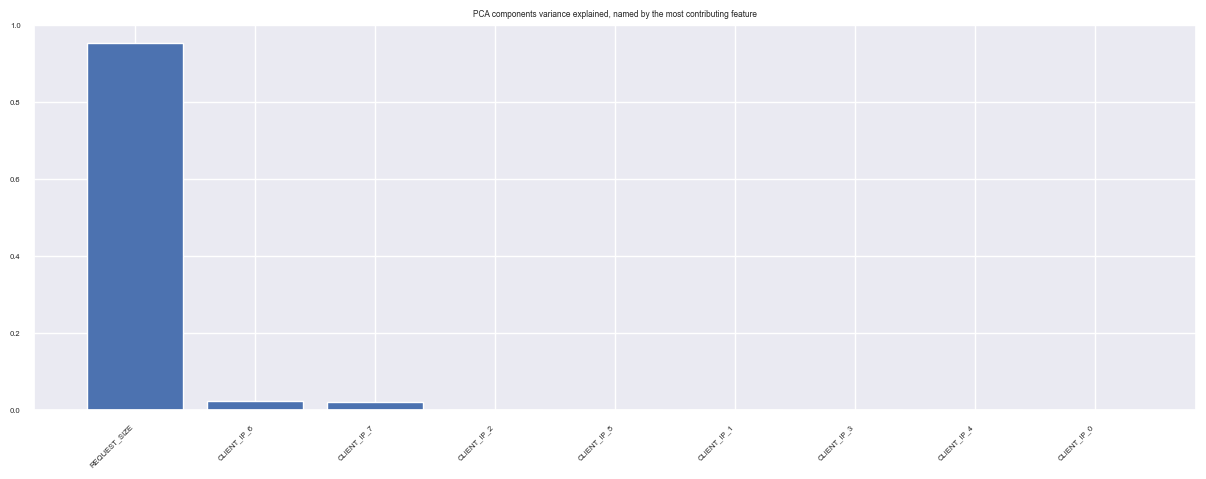

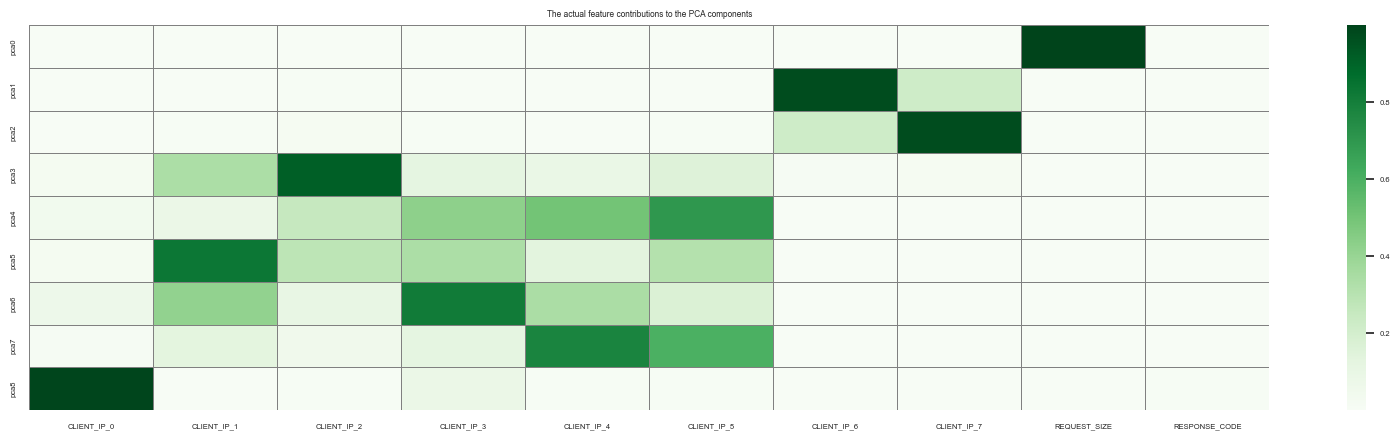

In [28]:
# Plot the resulting feature space data
plot_variance_explained(extractor_05)

In [29]:
%%capture
# Compute the feature space projection
X_05_proj = create_2d_projection(X_05)

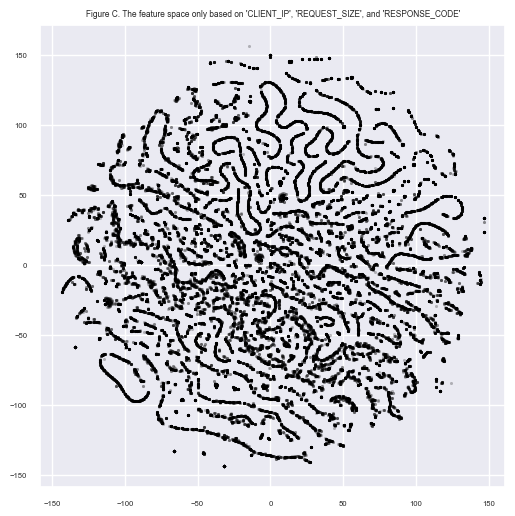

In [30]:
# Plot the resulting feature space in 2D
plot_2d_feature_space(X_05_proj, title="Figure C. The feature space only based on 'CLIENT_IP', 'REQUEST_SIZE', and 'RESPONSE_CODE'")

In [31]:
#############################################################################
# Summary of observations:
#    Note: The following holds for both for scaling being on and off, can be re-run
#    with is_scale=False for FeatureExtractor.
#
#    Observation 01: Figure A. and B. indicate that applying PCA to the feature space
#                    Improves its structure by making the clusters on projection more dense
#    
#    Observation 02: Based on the experiments (00-04) with removing data columns and doing PCA
#                    on the remaining ones, it looks like REQUEST_SIZE, CLIENT_IP, and 
#                    RESPONSE_CODE column values shall have the largest impact on the
#                    feature space and the other columns may be ignored
#
#    Observation 03: From the Experiment 05, one can see from Figure B. and C. that
#                    Ignoring all but REQUEST_SIZE, CLIENT_IP, and  RESPONSE_CODE
#                    columns for extracting features results in event cleaner cut/denser
#                    looking 2D cliuster projections. In other words, the impact of
#                    ignoring other columns is not that marginal.
#
# Conclusion:
#     Given the observations above, it is more robust to use all the
#     data columns and then to run PCA to project to a lower dimensional
#     space instead of exclusing data columns. So use the X_01 data.
#
#############################################################################

In [32]:
from src.utils.file_utils import store_numpy_zc

# Store the resulting features into file for further use
file_name = os.path.join(data_folder, 'X')
store_numpy_zc(file_name, X=X_01)

14:45:50 INFO (file_utils:26): Dumping compressed numpy z file into: ./data/X.npz
14:45:50 INFO (file_utils:28): File dumping is done!


In [35]:
from src.utils.file_utils import dump_pickle_data

# Dump the feature extractor for future use
dump_pickle_data(data_folder, 'extractor', extractor_01)

14:48:17 INFO (file_utils:10): Dumping pickle file into: ./data/extractor.pkl
